In [ ]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 3.1 MB 12.8 MB/s 
     |████████████████████████████████| 596 kB 58.0 MB/s 
     |████████████████████████████████| 59 kB 8.4 MB/s 
     |████████████████████████████████| 895 kB 64.2 MB/s 
     |████████████████████████████████| 3.3 MB 57.6 MB/s 
     |████████████████████████████████| 1.2 MB 14.4 MB/s 


In [ ]:
# Mount Google drive to upload datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The path to the data on my drive
D = '/content/drive/My Drive/W266_Project_Data/pmi_data'

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import optim
import torch.nn.functional as F

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the paraphrase training, dev, and test sets created with punjabi
paraphrase_train = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_train_w_punjabi.csv")
paraphrase_train.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_dev = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_dev_w_punjabi.csv")
paraphrase_dev.drop(columns={"Unnamed: 0"}, inplace=True)

paraphrase_test = pd.read_csv(D+"/xml/amrita-paraphrase-exact/paraphrase_test_w_punjabi.csv")
paraphrase_test.drop(columns={"Unnamed: 0"}, inplace=True)

In [ ]:
# Filter the train, dev, and test datasets to filter by language origin (Aryan vs Dravidian)
aryan_train = paraphrase_train[(paraphrase_train.language_task == 'translate English to Hindi') | (paraphrase_train.language_task == 'translate English to Punjabi')]
aryan_dev = paraphrase_dev[(paraphrase_dev.language_task == 'translate English to Hindi') | (paraphrase_dev.language_task == 'translate English to Punjabi')]
aryan_test = paraphrase_test[(paraphrase_test.language_task == 'translate English to Hindi') | (paraphrase_test.language_task == 'translate English to Punjabi')]

drav_train = paraphrase_train[(paraphrase_train.language_task == 'translate English to Tamil') | (paraphrase_train.language_task == 'translate English to Malayalam')]
drav_dev = paraphrase_dev[(paraphrase_dev.language_task == 'translate English to Tamil') | (paraphrase_dev.language_task == 'translate English to Malayalam')]
drav_test = paraphrase_test[(paraphrase_test.language_task == 'translate English to Tamil') | (paraphrase_test.language_task == 'translate English to Malayalam')]

In [ ]:
# Set up the device to run on GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Create an instance of the tokenizer and model using Indic Bert
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', keep_accents=True)
model = AutoModel.from_pretrained('ai4bharat/indic-bert')

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['sop_classifier.classifier.bias', 'predictions.bias', 'sop_classifier.classifier.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def sentence_embeddings(device, tokenizer, model, sentences):
  """Create contextualized sentence embeddings
  
  Parameters:
  tokenizer: transformers tokenizer for creating word tokens
  model:
  sentences: sentences to generate sentence embeddings for
  """

  # Tokenize sentences and return PyTorch tensors
  encoded_input = tokenizer(sentences, padding=True, truncation=True, 
                            max_length=128, return_tensors='pt')
  encoded_input = encoded_input.to(device)
  
  # Pass the tokenized input to the model 
  with torch.no_grad():
    model.to(device)
    model_output = model(**encoded_input) 
  
  # Perform mean pooling to get total sentence embeddings
  sentence_embeddings = mean_pooling(model_output, 
                                     encoded_input['attention_mask'])
  
  return sentence_embeddings

In [ ]:
# An object to prepare the training and test data fields for use in the neural network
class SiameseNetworkDataset(Dataset): 
  def __init__(self,training_df, device, tokenizer, model):
    self.training_df=training_df
    self.sent1 = self.training_df['sentence_1'].tolist()
    self.sent2 = self.training_df['sentence_2'].tolist()
    self.language_task = self.training_df['language_task'].tolist()
    self.label = self.training_df['label'].tolist()
    self.device = device
    self.tokenizer = tokenizer
    self.model = model

  def __getitem__(self, index):
    sent1 = self.sent1[index]
    sent2 = self.sent2[index]
    task = self.language_task[index]
    label = self.label[index]

    # Get the sentence embeddings for sentences 1 and 2 for each row
    sent1_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent1)
    sent2_embeddings = sentence_embeddings(self.device, self.tokenizer, self.model, sent2)
    return sent1_embeddings, sent2_embeddings, task, torch.from_numpy(np.array(label)).long()

  def __len__(self):
    return len(self.training_df)

In [ ]:
# Create separate instances of the Siamese Network dataset class using training, dev, and testing data for the Aryan languages
aryan_siamese_train = SiameseNetworkDataset(aryan_train, device, tokenizer, model)
aryan_siamese_dev = SiameseNetworkDataset(aryan_dev, device, tokenizer, model)
aryan_siamese_test = SiameseNetworkDataset(aryan_test, device, tokenizer, model)

In [ ]:
# Create separate instances of the Siamese Network dataset class using training, dev, and testing data for the Dravidian languages
drav_siamese_train = SiameseNetworkDataset(drav_train, device, tokenizer, model)
drav_siamese_dev = SiameseNetworkDataset(drav_dev, device, tokenizer, model)
drav_siamese_test = SiameseNetworkDataset(drav_test, device, tokenizer, model)

In [ ]:
# Get the label for every row in the training dataset and convert it to tensor form
aryan_target_list = []

for sent1, sent2, task, label in aryan_siamese_train:
  aryan_target_list.append(label)

# Store the torch form of the target label   
aryan_target_list = torch.tensor(aryan_target_list)

In [ ]:
# Get the label for every row in the training dataset and convert it to tensor form
drav_target_list = []

for sent1, sent2, task, label in drav_siamese_train:
  drav_target_list.append(label)

# Store the torch form of the target label   
drav_target_list = torch.tensor(drav_target_list)

In [ ]:
# Weight the labels by their frequency in the dataset - this will help our accuracy if there is an imbalance in classes (P vs NP)
aryan_class_count = [len(aryan_train[aryan_train.label == 0]),len(aryan_train[aryan_train.label == 1])]
print(aryan_class_count)
aryan_class_weights = 1./torch.tensor(aryan_class_count, dtype=torch.float) 
print(aryan_class_weights)

[2500, 1700]
tensor([0.0004, 0.0006])


In [ ]:
# Weight the labels by their frequency in the dataset - this will help our accuracy if there is an imbalance in classes (P vs NP)
drav_class_count = [len(drav_train[drav_train.label == 0]),len(drav_train[drav_train.label == 1])]
print(drav_class_count)
drav_class_weights = 1./torch.tensor(drav_class_count, dtype=torch.float) 
print(drav_class_weights)

[3000, 2000]
tensor([0.0003, 0.0005])


In [ ]:
# Create a list of the weighted labels to pass to the dataloader objects
aryan_class_weights_all = aryan_class_weights[aryan_target_list]
drav_class_weights_all = drav_class_weights[drav_target_list]

In [ ]:
# Create the weighted sampler object to pass to the training data loader
aryan_weighted_sampler = WeightedRandomSampler(
    weights=aryan_class_weights_all,
    num_samples=len(aryan_class_weights_all),
    replacement=True
)
drav_weighted_sampler = WeightedRandomSampler(
    weights=drav_class_weights_all,
    num_samples=len(drav_class_weights_all),
    replacement=True
)

In [ ]:
# Pass the training data into the training loader 
aryan_train_loader = DataLoader(aryan_siamese_train, batch_size = 16, sampler=aryan_weighted_sampler)

# Create the dev and test data loaders
aryan_val_loader = DataLoader(aryan_siamese_dev, batch_size=16)
aryan_test_loader = DataLoader(aryan_siamese_test, batch_size=16)

In [ ]:
# Pass the training data into the training loader 
drav_train_loader = DataLoader(drav_siamese_train, batch_size = 16, sampler=drav_weighted_sampler)

# Create the dev and test data loaders
drav_val_loader = DataLoader(drav_siamese_dev, batch_size=16)
drav_test_loader = DataLoader(drav_siamese_test, batch_size=16)

In [ ]:
class SiameseNet(torch.nn.Module):
    def __init__(self):
      super(SiameseNet, self).__init__()

      # Set up a fully-connected layer to apply to each incoming sentence vector
      # Use a dense layer (nn.Linear) to reduce the dimensionality of the input embeddings
      # use a relu activation function
      self.fc = torch.nn.Sequential(
            torch.nn.Linear(768, 128),
            torch.nn.LayerNorm(128),
            torch.nn.ReLU(inplace=True))
      
      self.relu = torch.nn.ReLU(inplace=True)
      self.batch2 = torch.nn.LayerNorm(384)
      self.ffn = torch.nn.Linear(384, 128)
      self.batch3 = torch.nn.LayerNorm(128)
      self.layer_out = torch.nn.Linear(128,1)

      # Add drop out
      self.drop = torch.nn.Dropout(0.2)

    # left and right represent columns in our data
    def forward(self, left, right):

      # Get the sentence embeddings 
      u = left
      v = right

      # Reduce the dimensionality
      u = self.fc(u)
      v = self.fc(v)

      # Get the absolute value of the element-wise difference of the embedding vectors
      uv = torch.sub(u, v)
      uv_abs = torch.abs(uv)

      # concatenate u, v, and the absolute value of the element-wise difference between the embeddings
      x = torch.cat([u, v, uv_abs], dim=-1)

      # Normalize the concatenated batch
      x = self.batch2(x)

      # Use the relu activation function
      x = self.relu(x)

      # Pass the concatenated layers through a dense layer to reduce the dimensionality
      x = self.ffn(x)
      # Normalize the concatenated layers
      x = self.batch3(x)
      # Pass through relu activation
      x = self.relu(x)
      # Implement drop out to avoid overfitting
      x = self.drop(x)
      # Pass the output through a final dense layer
      output = self.layer_out(x)
      # Reshape the output to have the same dimension as the target labels
      output = output[:,-1,:]

      return output

In [ ]:
# Create instances of the Siamese model network
aryan_net = SiameseNet().to(device)
drav_net = SiameseNet().to(device)

# Set the criteria for evaluation and training - use cross-entropy since we're doing classification and want to retrieve the labels
criterion = torch.nn.BCEWithLogitsLoss()

# Set the optimizer and pass to it the model parameters and learning rate
aryan_optimizer = optim.Adam(aryan_net.parameters(), lr=2e-5)
drav_optimizer = optim.Adam(drav_net.parameters(), lr=2e-5)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

The validation metrics below correspond to the validation dataset containing duplicates. The training metrics are accurate, however. Validation metrics calculated on the de-duplicated dataset can be found in the Dedup_snn_eval folder.

In [ ]:
# Create dictionaries to hold the training and validation accuracy and loss metrics at each epoch
aryan_epoch_accuracies = {
    'train': [],
    "val": []}

aryan_epoch_losses = {
    'train': [],
    "val": []}

drav_epoch_accuracies = {
    'train': [],
    "val": []}

drav_epoch_losses = {
    'train': [],
    "val": []}

In [ ]:
EPOCHS = 10

for e in tqdm(range(1, EPOCHS+1)):
    
    # Initialize the training epoch and accuracy loss as 0
    train_epoch_loss = 0
    train_epoch_acc = 0

    # Place the Siamese network into training mode
    aryan_net.train()
    
    # Loop over records in the training data loader
    for i, data in enumerate(aryan_train_loader, 0):
      sent1, sent2, task, label = data
      label = label.type(torch.FloatTensor).reshape((label.shape[0], 1))
      # Send the training data to GPU
      sent1, sent2, label = sent1.to(device), sent2.to(device), label.to(device)
      # Zero the gradient
      aryan_optimizer.zero_grad()
      # Get the predicted softmaxes
      train_pred = aryan_net(sent1, sent2)
      # Get the predicted labels
      train_loss = criterion(train_pred, label)
      # Find the training rate accuracy
      train_acc = binary_acc(train_pred, label)
      
      train_loss.backward()
      aryan_optimizer.step()

      # Update the loss and accuracy for the current epoch  
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()   
        
    # Enter validation phase   
    with torch.no_grad():
        
        # Initialize the validation loss and accuracy rates as 0
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        # Place the model into evaluation mode
        aryan_net.eval()

        # Loop over records in the validation dataloader
        for i, data in enumerate(aryan_val_loader, 0):
          sent1_val, sent2_val, task_val, label_val = data
          label_val = label_val.type(torch.FloatTensor).reshape((label_val.shape[0], 1))

          # Send the validation data to GPU
          sent1_val, sent2_val, label_val = sent1_val.to(device), sent2_val.to(device), label_val.to(device)

          # Get the validation predictions          
          val_pred = aryan_net(sent1_val, sent2_val)
          # Find the validation loss and accuracy
          val_loss = criterion(val_pred, label_val)
          val_acc = binary_acc(val_pred, label_val)
          
          # Update the validation loss and accuracy rates
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
    
    # Store the epoch's training and validaion accuracies and losses
    aryan_epoch_losses['train'].append(train_epoch_loss/len(aryan_train_loader))
    aryan_epoch_losses['val'].append(val_epoch_loss/len(aryan_val_loader))
    aryan_epoch_accuracies['train'].append(train_epoch_acc/len(aryan_train_loader))
    aryan_epoch_accuracies['val'].append(val_epoch_acc/len(aryan_val_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
aryan_epoch_accuracies

{'train': [62.950570342205324,
  79.30798479087453,
  85.68441064638783,
  89.05703422053232,
  91.39923954372624,
  92.24334600760456,
  94.69961977186311,
  95.04562737642586,
  95.93916349809886,
  96.77566539923954],
 'val': [71.86363636363636,
  87.6590909090909,
  88.0,
  88.29545454545455,
  88.02272727272727,
  89.43181818181819,
  89.02272727272727,
  90.18181818181819,
  91.4090909090909,
  91.29545454545455]}

In [ ]:
aryan_epoch_losses

{'train': [0.6433095445877699,
  0.5293362044336225,
  0.4415260088761043,
  0.37706001233238684,
  0.32430181077224673,
  0.29279087353568567,
  0.24294572028936995,
  0.22094281609860664,
  0.19424626783613017,
  0.16951897663875223],
 'val': [0.5784422477537935,
  0.45950829915025015,
  0.39524955370209436,
  0.35900111733512446,
  0.3363849696787921,
  0.3003674005581574,
  0.295997218652205,
  0.27051715535873716,
  0.25894876721907745,
  0.2448067023334178]}

In [ ]:
EPOCHS = 10

for e in tqdm(range(1, EPOCHS+1)):
    
    # Initialize the training epoch and accuracy loss as 0
    train_epoch_loss = 0
    train_epoch_acc = 0

    # Place the Siamese network into training mode
    drav_net.train()
    
    # Loop over records in the training data loader
    for i, data in enumerate(drav_train_loader, 0):
      sent1, sent2, task, label = data
      label = label.type(torch.FloatTensor).reshape((label.shape[0], 1))
      # Send the training data to GPU
      sent1, sent2, label = sent1.to(device), sent2.to(device), label.to(device)
      # Zero the gradient
      drav_optimizer.zero_grad()
      # Get the predicted softmaxes
      train_pred = drav_net(sent1, sent2)
      # Get the predicted labels
      train_loss = criterion(train_pred, label)
      # Find the training rate accuracy
      train_acc = binary_acc(train_pred, label)
      
      train_loss.backward()
      drav_optimizer.step()

      # Update the loss and accuracy for the current epoch  
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()   
        
    # Enter validation phase   
    with torch.no_grad():
        
        # Initialize the validation loss and accuracy rates as 0
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        # Place the model into evaluation mode
        drav_net.eval()

        # Loop over records in the validation dataloader
        for i, data in enumerate(drav_val_loader, 0):
          sent1_val, sent2_val, task_val, label_val = data
          label_val = label_val.type(torch.FloatTensor).reshape((label_val.shape[0], 1))

          # Send the validation data to GPU
          sent1_val, sent2_val, label_val = sent1_val.to(device), sent2_val.to(device), label_val.to(device)

          # Get the validation predictions          
          val_pred = drav_net(sent1_val, sent2_val)
          # Find the validation loss and accuracy
          val_loss = criterion(val_pred, label_val)
          val_acc = binary_acc(val_pred, label_val)
          
          # Update the validation loss and accuracy rates
          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item()
    
    # Store the epoch's training and validaion accuracies and losses
    drav_epoch_losses['train'].append(train_epoch_loss/len(drav_train_loader))
    drav_epoch_losses['val'].append(val_epoch_loss/len(drav_val_loader))
    drav_epoch_accuracies['train'].append(train_epoch_acc/len(drav_train_loader))
    drav_epoch_accuracies['val'].append(val_epoch_acc/len(drav_val_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
drav_epoch_accuracies

{'train': [58.42811501597444,
  69.3929712460064,
  74.33546325878594,
  77.80830670926518,
  79.73162939297124,
  80.63258785942492,
  83.99680511182109,
  84.64856230031948,
  86.21086261980831,
  87.21405750798722],
 'val': [56.526315789473685,
  61.175438596491226,
  65.14035087719299,
  65.87719298245614,
  66.94736842105263,
  68.08771929824562,
  68.12280701754386,
  68.9298245614035,
  70.6140350877193,
  69.85964912280701]}

In [ ]:
drav_epoch_losses

{'train': [0.6719470035534697,
  0.6000269598092515,
  0.5500634842977737,
  0.5073217162118552,
  0.4712253883242988,
  0.45260888028639956,
  0.4129230477177678,
  0.38841473580168456,
  0.366302061480836,
  0.3466270862581631],
 'val': [0.6858585152709693,
  0.6624945428287774,
  0.6335699234092445,
  0.621336999692415,
  0.6268659918977503,
  0.6112678610441977,
  0.6287369848343364,
  0.6151068011919657,
  0.6064127024851347,
  0.6169061796707019]}

In [ ]:
print(max(aryan_epoch_accuracies.get('train')))
print(max(aryan_epoch_accuracies.get('val')))

print(max(drav_epoch_accuracies.get('train')))
print(max(drav_epoch_accuracies.get('val')))

96.77566539923954
91.4090909090909
87.21405750798722
70.6140350877193


In [ ]:
print(min(aryan_epoch_accuracies.get('train')))
print(min(aryan_epoch_accuracies.get('val')))

print(min(drav_epoch_accuracies.get('train')))
print(min(drav_epoch_accuracies.get('val')))

62.950570342205324
71.86363636363636
58.42811501597444
56.526315789473685


In [ ]:
print(min(aryan_epoch_losses.get('train')))
print(max(aryan_epoch_losses.get('train')))

print(min(drav_epoch_losses.get('train')))
print(max(drav_epoch_losses.get('train')))

0.16951897663875223
0.6433095445877699
0.3466270862581631
0.6719470035534697


In [ ]:
print(min(aryan_epoch_losses.get('val')))
print(max(aryan_epoch_losses.get('val')))

print(min(drav_epoch_losses.get('val')))
print(max(drav_epoch_losses.get('val')))

0.2448067023334178
0.5784422477537935
0.6064127024851347
0.6858585152709693


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

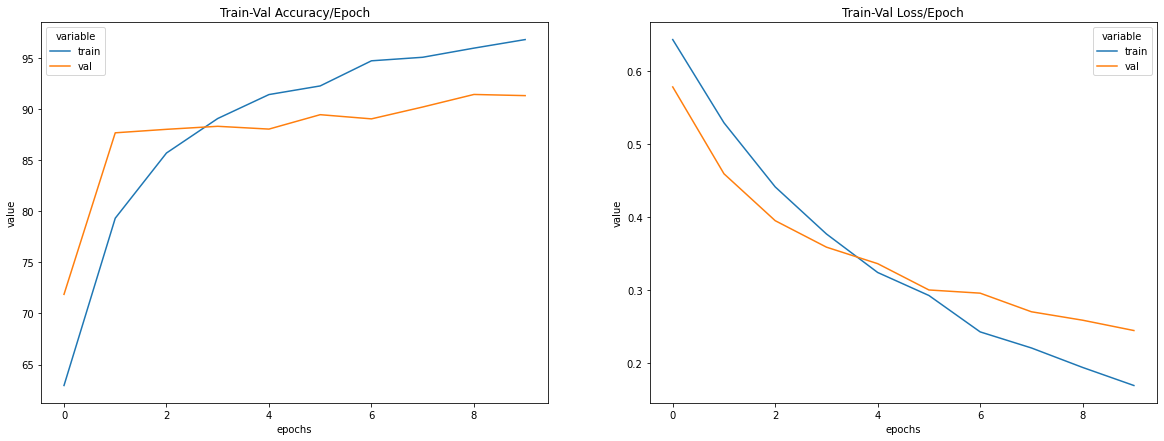

In [ ]:
# Create dataframes from the average training accuracy and loss 
train_val_acc_df = pd.DataFrame.from_dict(aryan_epoch_accuracies).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(aryan_epoch_losses).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

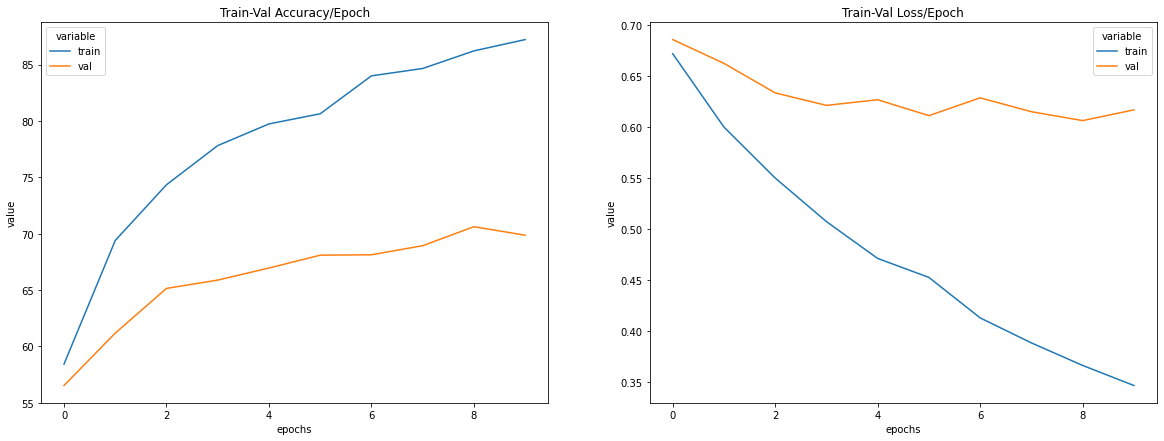

In [ ]:
# Create dataframes from the average training accuracy and loss 
train_val_acc_df = pd.DataFrame.from_dict(drav_epoch_accuracies).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(drav_epoch_losses).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
# Save the weights and biases
torch.save(aryan_net.state_dict(), "/content/drive/My Drive/W266_Project_Data/models/siamese_model/aryan_model_layernorm.pt")
torch.save(drav_net.state_dict(), "/content/drive/My Drive/W266_Project_Data/models/siamese_model/drav_model_layernorm.pt")

print("Model Saved")

Model Saved
